# Analyzing Austin PD's Crime Reports Dataset

The Austin Police Department's Crime Reports dataset provides valuable information about reported crimes in Austin, Texas. In this analysis, we will explore the dataset and gain insights into various aspects of crime in Austin.

## Table of Contents 

I. Introduction
II. Data Scrubbing
III. Exploratory Analysis

## I. Introduction

The Austin Police Department's Crime Reports dataset offers a comprehensive view of reported crimes in Austin, Texas. By analyzing this dataset, we can extract valuable insights into the nature and patterns of crime in the city.

## II. Data Preparation

Before conducting any analysis, it is crucial to clean and preprocess the dataset. The data scrubbing process involves addressing missing data, removing irrelevant columns, and ensuring data types are appropriate.

## III. Exploratory Analysis

Once the dataset is scrubbed and prepared, we can perform an exploratory analysis to gain a deeper understanding of the crime data. The exploratory analysis may include the following:

1. Overall crime trends over time: We can examine the total number of reported crimes each year to identify any noticeable patterns or changes.

2. Crime distribution by category: Analyzing the distribution of crimes by category can provide insights into the most prevalent types of crimes in Austin.

3. Crime distribution by location: Exploring the locations where crimes occur most frequently can help identify high-crime areas or hotspots.

4. Crime distribution by time of day: Investigating the temporal patterns of crime by analyzing the frequency of crimes during different times of the day or week.

5. Crime correlations: Exploring potential correlations between different types of crimes or examining the relationship between crime and other factors such as location, time, or demographic variables.

6. Crime mapping: Visualizing the spatial distribution of crimes on a map can help identify clusters or spatial patterns.

These are just a few examples of the exploratory analysis that can be performed using the Austin PD's Crime Reports dataset. The specific analysis and insights will depend on the available data and the research questions of interest.

Let's proceed with the data scrubbing phase to ensure the dataset is clean and ready for analysis.

**I. Introduction**
I started reviewing the Crime Reports dataset provided by the Austin PD around the beginning of 2020, along with the Hate Crimes datasets. The dataset is quite extensive, containing over 2 million records from 2003 to the present, and it is updated on a weekly basis.

This project is self-paced and not affiliated with any work or educational institution. My goal is to uncover valuable insights that can benefit the Austin law enforcement community, news outlets, and anyone interested in understanding and addressing crime-related issues in the Austin area.

Initially, I attempted to import the data into this notebook using Sodapy's Socrata API method. However, I found it to be insufficient as it didn't import the complete dataset and added redundant columns. As a result, I decided to manually download the entire dataset and repeat the process each week after the updates.

In [1]:
# importing necessary libraries and configurations
import folium
from folium import plugins

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import itertools
import warnings

pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
plt.style.use("seaborn-white")
sb.set_style("whitegrid")
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv("/kaggle/input/crime-reports-06152023/Crime_Reports.csv")

In [3]:
# examining the dataframe
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2377481 entries, 0 to 2377480
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 137
Occurred Date                        0
Occurred Time                       60
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    19007
Address                             13
Zip Code                          9922
Council District                 41985
APD Sector                        4444
APD District                      5068
PRA                               6496
Census Tract                     17996
Clearance Status                606136
Clearance Date                  337704
UCR Category                   1504295
Category Description           1504295
X-coordinate                      5969
Y-coordinate                      5962
Latitude                         37525
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20072790876,DISTURBANCE - OTHER,3401,N,10/05/2007 11:00:00 PM,10/05/2007,2300.0,10/06/2007 11:46:00 AM,10/06/2007,1146.0,RESIDENCE / HOME,11708 KINGVIEW CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20065065520,FRAUD - OTHER,1199,N,11/14/2006 12:00:00 AM,11/14/2006,0.0,11/14/2006 12:00:00 AM,11/14/2006,0.0,OTHER / UNKNOWN,2300 W NORTH LOOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003421480455,CUSTODY ARREST TRAFFIC WARR,3722,N,05/28/2003 08:16:00 AM,05/28/2003,816.0,05/28/2003 08:16:00 AM,05/28/2003,816.0,RESIDENCE / HOME,6808 GRANGER DR,NaN,NaN,NaN,NaN,0,NaN,N,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,20052602038,DOC UNREASONABLE NOISE,2405,N,NaN,09/17/2005,NaN,09/17/2005 09:45:00 PM,09/17/2005,2145.0,NaN,5500 TUMBLEWEED DR,NaN,NaN,CH,10,NaN,NaN,NaN,10/17/2005,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20065065524,FRAUD - OTHER,1199,N,11/14/2006 12:00:00 AM,11/14/2006,0.0,11/14/2006 12:00:00 AM,11/14/2006,0.0,OTHER / UNKNOWN,2300 W NORTH LOOP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12/13/2006,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2377476,20173630952,FAMILY DISTURBANCE,3400,N,12/29/2017 05:23:00 PM,12/29/2017,1723.0,12/29/2017 05:23:00 PM,12/29/2017,1723.0,RESIDENCE / HOME,5420 MIDDLE FISKVILLE RD,78751.0,4.0,ID,6,290.0,15.00,NaN,NaN,NaN,NaN,3122811.0,10088806.0,30.317142,-97.714549,"(30.31714242, -97.7145492)"
2377477,20135014041,BURGLARY OF VEHICLE,601,N,04/03/2013 07:37:00 AM,04/03/2013,737.0,04/03/2013 07:37:00 AM,04/03/2013,737.0,RESIDENCE / HOME,313 THELMA DR,78745.0,2.0,FR,3,527.0,24.22,N,04/09/2013,23F,Theft,3101406.0,10042886.0,30.192282,-97.785702,"(30.19228199, -97.78570242)"
2377478,2006440576,FAMILY DISTURBANCE,3400,N,02/13/2006 09:00:00 AM,02/13/2006,900.0,02/13/2006 09:42:00 AM,02/13/2006,942.0,RESIDENCE / HOME,2612 GARRETTSON DR,78748.0,5.0,FR,1,100.0,318.00,NaN,NaN,NaN,NaN,3086248.0,10036456.0,30.175552,-97.834125,"(30.17555215, -97.8341253)"
2377479,20155015531,THEFT,600,N,04/13/2015 08:00:00 AM,04/13/2015,800.0,04/13/2015 05:37:00 PM,04/13/2015,1737.0,COMMERCIAL / OFFICE BUILDING,4625 W WILLIAM CANNON DR,78749.0,8.0,DA,7,83.0,312.00,N,04/14/2015,23H,Theft,3082868.0,10053773.0,30.223363,-97.843593,"(30.22336296, -97.84359263)"
2377480,2019111106,DISTURBANCE - OTHER,3401,N,01/11/2019 04:29:00 PM,01/11/2019,1629.0,01/11/2019 04:29:00 PM,01/11/2019,1629.0,PARKING /DROP LOT/ GARAGE,7401 N LAMAR BLVD,78752.0,4.0,ID,8,264.0,400.00,N,01/22/2019,NaN,NaN,3122178.0,10097341.0,30.340645,-97.715918,"(30.34064472, -97.7159184)"


## II. Data Preparation

In this section, we will perform data preparation steps to clean and organize the crime reports data.

### 1. Cleaning the Data

Next, we clean the data using the `clean_data` function. This function performs the following operations:

- Drops unnecessary columns: We remove the columns that are not needed for our analysis.
- Renames columns: We standardize the column names by removing leading/trailing spaces and replacing spaces with underscores.
- Fills missing values: We replace missing values in specific columns with "Unknown".
- Converts data types: We convert certain columns to the appropriate data types, such as categorical and datetime.
- Creates additional time-based columns: We extract year, month, week, day, and hour information from the "occurred_date_time" column.
- Sets and sorts the index: We set the "occurred_date_time" column as the index and sort the data by the index.

### 2. Removing Duplicates

We check for and remove any duplicate rows in the dataset.

### 3. Analyzing Crime Rates

We display dataframes showing the crime rates by zip code, both in counts and percentages.

### 4. Visualizing Crime Rates

We create visualizations to visualize the top 25 crime-ridden zip codes in Austin. We plot a bar chart showing the total crimes for each zip code, as well as a time series plot with a 12-month rolling average of the total crimes per month.

The following code provides a reproducible script for performing the data preparation steps and generating the necessary visualizations.

In [4]:
def clean_data(df):
    """
    Clean the crime data by removing unnecessary columns, renaming columns, filling missing values,
    converting data types, and creating additional time-based features.

    Args:
        df (pandas.DataFrame): Crime data.

    Returns:
        pandas.DataFrame: Cleaned crime data.
    """
    drop_col = [
        "Highest Offense Code",
        "Incident Number",
        "Occurred Time",
        "Occurred Date Time",
        "Report Date",
        "Report Time",
        "UCR Category",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df.drop(drop_col, axis=1, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    
    fillna_cols = [
        "zip_code",
        "location_type",
        "council_district",
        "pra",
        "census_tract",
        "location_type",
        "apd_district",
        "apd_sector",
        "clearance_status",
        "category_description",
    ]
    df[fillna_cols].fillna("Unknown", inplace=True)

    date_cols = ["occurred_date", "report_date_time", "clearance_date"]
    cat_cols = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
        "pra",
        "census_tract",
        "category_description",
    ]

    df.family_violence.replace({"Y": "True", "N": "False"}, inplace=True)
    df.clearance_status.replace({"C": "True", "O": "True", "N": "False"}, inplace=True)

    df[cat_cols] = df[cat_cols].astype("category")
    df[date_cols] = df[date_cols].astype("datetime64")

    df["year"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.day
    # df["hour"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.hour

    df.set_index(["occurred_date"], inplace=True)
    df.sort_index(inplace=True)
    
    return df

df = clean_data(df)



In [5]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [6]:
# Re-examining the dataframe
display(df.info())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2376703 entries, 2003-01-01 to 2023-05-06
Data columns (total 20 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   pra                          category      
 10  census_tract                 category      
 11  clearance_status             object        
 12  clearance_date               datetime64[ns]
 13  category_description         category      
 14  latitude                     float64       
 15  longitude                    float

None

,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,census_tract,clearance_status,clearance_date,category_description,latitude,longitude,year,month,week,day
occurred_date,,,,,,,,,,,,,,,,,,,,
2003-01-01,CRIMINAL MISCHIEF,False,2004-01-05 15:48:00,PARKING /DROP LOT/ GARAGE,9700 STONELAKE BLVD,78759.0,7.0,AD,1,216.0,324.00,NaN,2004-02-09,NaN,30.387691,-97.739275,2003,1,1,1
2003-01-01,IDENTITY THEFT,False,2009-08-07 14:23:00,RESIDENCE / HOME,6800 MC NEIL DR,78729.0,6.0,AD,4,169.0,204.10,NaN,NaT,NaN,30.438983,-97.759669,2003,1,1,1
2003-01-01,CRIMINAL TRESPASS,False,2003-01-01 17:24:00,RESIDENCE / HOME,1104 E OLTORF ST,78704.0,9.0,HE,1,478.0,23.23,False,2003-01-06,NaN,30.235381,-97.744890,2003,1,1,1
2003-01-01,HARASSMENT,False,2003-02-12 09:34:00,RESIDENCE / HOME,10708 BARNHILL DR,78758.0,4.0,ED,1,239.0,409.00,False,NaT,NaN,30.379988,-97.696816,2003,1,1,1
2003-01-01,VIOL CITY ORDINANCE - DOG,False,2003-01-01 15:42:00,HWY / ROAD / ALLEY/ STREET/ SIDEWALK,4500 BLOCK PELHAM DR,78727.0,7.0,AD,3,192.0,413.00,False,2003-01-01,NaN,30.422147,-97.725540,2003,1,1,1


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,pra,census_tract,clearance_status,clearance_date,category_description,latitude,longitude,year,month,week,day
occurred_date,,,,,,,,,,,,,,,,,,,,
2023-05-06,DEADLY CONDUCT,False,2023-05-06 16:27:00,RESIDENCE / HOME,2401 ALDRICH ST,78723.0,9.0,BA,4,900.0,3.00,NaN,NaT,Aggravated Assault,30.302356,-97.702154,2023,5,18,6
2023-05-06,ASSAULT W/INJURY-FAM/DATE VIOL,True,2023-05-06 04:42:00,RESIDENCE / HOME,8526 CORNWALL DR,78748.0,2.0,FR,3,536.0,24.23,NaN,NaT,NaN,30.178463,-97.800036,2023,5,18,6
2023-05-06,ASSAULT W/INJURY-FAM/DATE VIOL,True,2023-05-06 15:42:00,RESIDENCE / HOME,5701 S MOPAC EXPY SVRD NB,78749.0,8.0,DA,4,79.0,321.00,NaN,NaT,NaN,30.227932,-97.828811,2023,5,18,6
2023-05-06,AUTO THEFT,False,2023-05-06 20:03:00,PARKING /DROP LOT/ GARAGE,2609 E CESAR CHAVEZ ST,78702.0,3.0,CH,1,420.0,10.00,False,2023-05-06,Auto Theft,30.253348,-97.714702,2023,5,18,6
2023-05-06,DATING DISTURBANCE,False,2023-05-06 03:55:00,RESIDENCE / HOME,8205 WASHITA DR,78749.0,8.0,DA,7,86.0,335.00,False,2023-05-06,NaN,30.205701,-97.847293,2023,5,18,6


## III. Exploratory Analysis

In this section, we will perform exploratory analysis to determine the areas of Austin with the highest crime rates.

### A. Crime Rates by Area

To identify the areas of Austin with the highest crime rates, we will analyze the distribution of crimes across different areas. We will focus on the zip codes as the primary area indicator in our dataset.

#### 1. Crime Rates by Zip Code

We start by examining the crime rates by zip code. The following code calculates the total number of crimes for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_by_zipcode = df["zip_code"].value_counts().head(10).to_frame()
display(crime_by_zipcode)

```

#### 2. Crime Rates as Percentages

In addition to the total crime counts, it is also informative to analyze the crime rates as percentages relative to the total. The following code calculates the crime rates as percentages for each zip code and displays the top 10 zip codes with the highest crime rates.

```python
crime_rates_by_zipcode = df["zip_code"].value_counts(normalize=True).head(10).to_frame()
display(crime_rates_by_zipcode)

```

#### 3. Visualizing Crime Rates by Zip Code

To visually represent the crime rates by zip code, we can create a bar chart. The following code generates a bar chart showing the top 10 zip codes with the highest crime rates.

```python
plt.figure(figsize=(10, 6))
crime_by_zipcode.plot(kind="bar", rot=45)
plt.title("Top 10 Zip Codes with Highest Crime Rates")
plt.xlabel("Zip Code")
plt.ylabel("Number of Crimes")
plt.show()

```

By analyzing the crime rates by area, specifically the zip codes, we can gain insights into the areas of Austin with the highest crime rates. This information can be valuable for understanding the distribution of crime and potentially identifying areas that require additional attention in terms of crime prevention and law enforcement efforts.

,zip_code
78741.0,215037
78753.0,184435
78758.0,166741
78701.0,164767
78704.0,156139
78745.0,151295
78702.0,135994
78744.0,128385
78723.0,126685
78752.0,89527


,zip_code
78741.0,0.090856
78753.0,0.077926
78758.0,0.070450
78701.0,0.069616
78704.0,0.065971
78745.0,0.063924
78702.0,0.057459
78744.0,0.054244
78723.0,0.053526
78752.0,0.037826


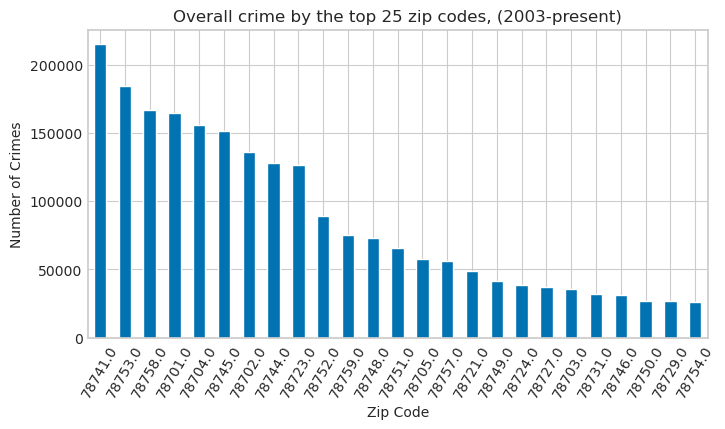

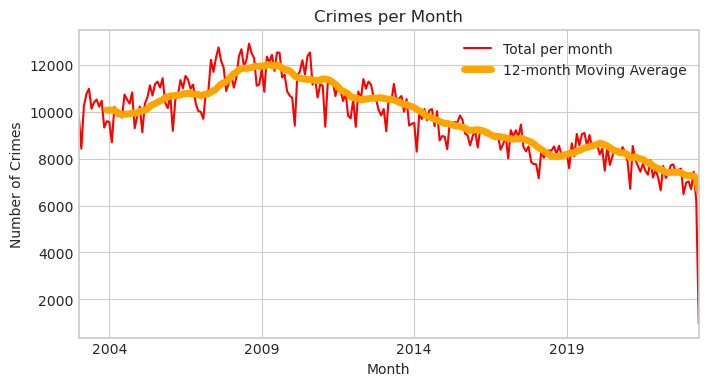

,highest_offense_description
BURGLARY OF VEHICLE,246964
THEFT,224136
FAMILY DISTURBANCE,199962
CRIMINAL MISCHIEF,137326
ASSAULT W/INJURY-FAM/DATE VIOL,85106
BURGLARY OF RESIDENCE,80642
DWI,72972
HARASSMENT,68652
DISTURBANCE - OTHER,66224
AUTO THEFT,54285


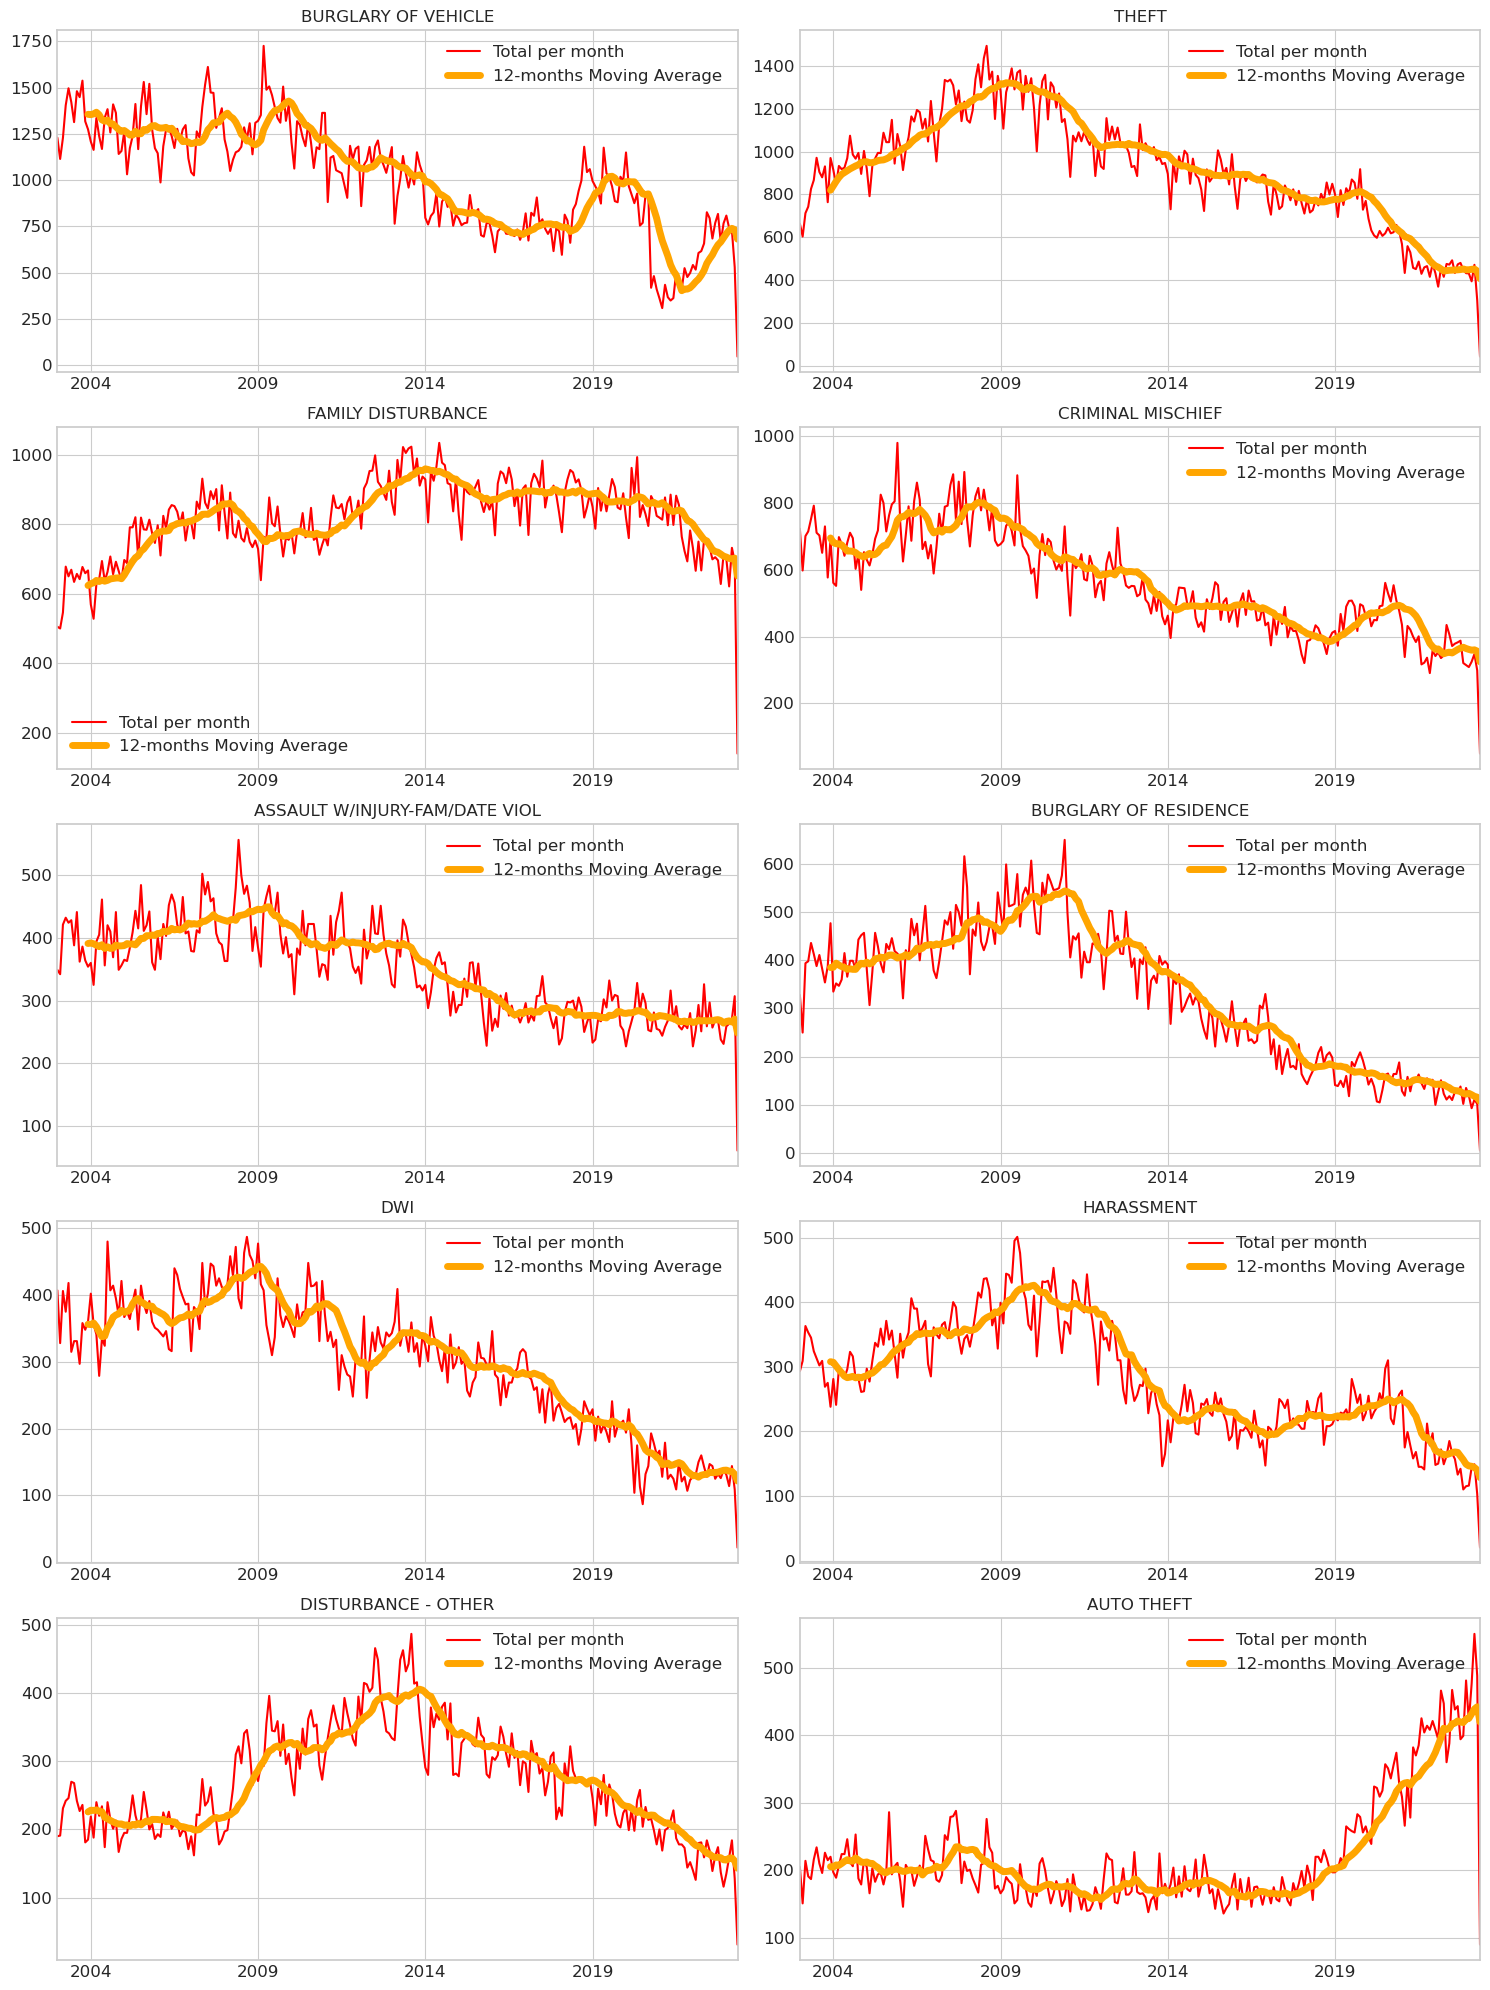

In [19]:
# Set colorblind-friendly palette
sb.set_palette("colorblind")
sb.set_style("whitegrid")

# Crime Rates by Zip Code

# Displaying dataframes for crime rates by zip code
crime_counts = df["zip_code"].value_counts().head(25).to_frame()
crime_percentages = df["zip_code"].value_counts(normalize=True).head(25).to_frame()

display(crime_counts)
display(crime_percentages)

# Visualizing the top 25 crime-ridden zip codes in Austin
plt.figure(figsize=(8, 4), dpi=100)
df["zip_code"].value_counts().head(25).plot.bar(rot=60)
plt.title("Overall crime by the top 25 zip codes, (2003-present)")
plt.xlabel("Zip Code")
plt.ylabel("Number of Crimes")
plt.show()

# Creating a time series plot with a 12-month rolling average
plt.figure(figsize=(8, 4), dpi=100)
monthly_crimes = df.resample("M").size()
monthly_crimes.plot(color="red", linewidth=1.5, label="Total per month")
monthly_crimes.rolling(window=12).mean().plot(
    color="orange", linewidth=5, label="12-month Moving Average"
)
plt.title("Crimes per Month")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.legend()
plt.show()

# Displaying top crime descriptions
top_crime_descriptions = (
    df["highest_offense_description"].value_counts().head(10).to_frame()
)
display(top_crime_descriptions)

# Analyzing monthly crime trends for selected offense descriptions
selected_crimes = [
    "BURGLARY OF VEHICLE",
    "THEFT",
    "FAMILY DISTURBANCE",
    "CRIMINAL MISCHIEF",
    "ASSAULT W/INJURY-FAM/DATE VIOL",
    "BURGLARY OF RESIDENCE",
    "DWI",
    "HARASSMENT",
    "DISTURBANCE - OTHER",
    "AUTO THEFT",
]
df_selected = df[df["highest_offense_description"].isin(selected_crimes)]

monthly = df_selected.resample("M").size().to_frame(name="TOTAL")
for crime in selected_crimes:
    monthly[crime] = (
        df_selected[df_selected["highest_offense_description"] == crime]
        .resample("M")
        .size()
    )
# Plotting monthly crime trends for selected offenses
plt.figure(figsize=(15, 20), dpi=100)
for i, crime in enumerate(selected_crimes, 1):
    ax = plt.subplot(5, 2, i)
    monthly[crime].plot(color="red", linewidth=1.5, label="Total per month")
    monthly[crime].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12-months Moving Average"
    )
    plt.title(crime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()



### How is crime distributed in 78701 (downtown Austin)? 

,highest_offense_description
THEFT,17048
BURGLARY OF VEHICLE,10164
WARRANT ARREST NON TRAFFIC,9110
DWI,8688
ASSAULT WITH INJURY,8440
CRIMINAL MISCHIEF,6524
POSS OF DRUG PARAPHERNALIA,6391
VIOL CITY ORDINANCE - OTHER,6274
CRIMINAL TRESPASS,4348
DISTURBANCE - OTHER,3679


,highest_offense_description
THEFT,0.103467
BURGLARY OF VEHICLE,0.061687
WARRANT ARREST NON TRAFFIC,0.055290
DWI,0.052729
ASSAULT WITH INJURY,0.051224
CRIMINAL MISCHIEF,0.039595
POSS OF DRUG PARAPHERNALIA,0.038788
VIOL CITY ORDINANCE - OTHER,0.038078
CRIMINAL TRESPASS,0.026389
DISTURBANCE - OTHER,0.022329


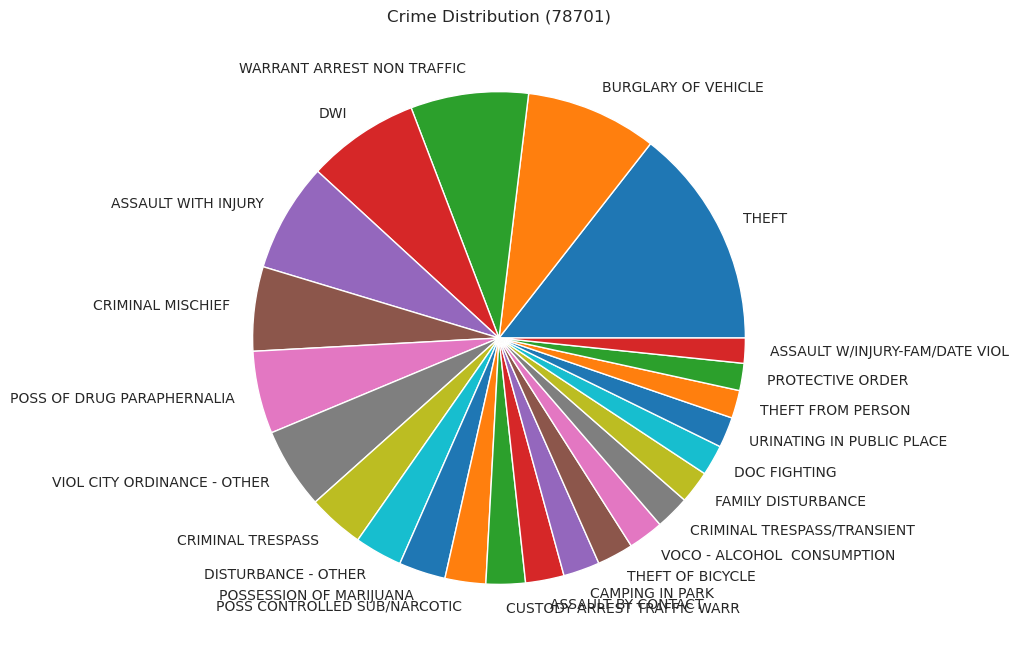

In [8]:
# Filtering data for the 78701 area
df_01 = df[df['zip_code'] == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01['highest_offense_description'].value_counts().head(24)

# Display the count of different crime categories
display(df_01_off.to_frame())

# Display the crime categories as percentages
display(df_01['highest_offense_description'].value_counts(normalize=True).head(24).to_frame())

# Plotting a pie chart for crime distribution in 78701
plt.figure(figsize=(8, 8), dpi=100)
df_01_off.plot.pie(title="Crime Distribution (78701)")
plt.ylabel('')  # Remove y-label
plt.show()


### To analyze other zip codes, simply update the 'zip_code' variable accordingly.


### How are violent crimes distributed? 

In [20]:
# Creating separate dataframes for violent crime & murder rates
df_viol = df.query(
    'category_description == ["Aggravated Assault", "Robbery", "Rape", "Murder"]'
)
df_mur = df[df.category_description == "Murder"]
df_agg_asslt = df[df.category_description == "Aggravated Assault"]
df_robbery = df[df.category_description == "Robbery"]
df_rape = df[df.category_description == "Rape"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]
df_21 = df[df.year == 2021]
df_22 = df[df.year == 2022]


# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]
df_viol_21 = df_viol[df_viol.year == 2021]
df_viol_22 = df_viol[df_viol.year == 2022]

# Annual murders
df_mur_17 = df_mur[df_mur.year == 2017]
df_mur_18 = df_mur[df_mur.year == 2018]
df_mur_19 = df_mur[df_mur.year == 2019]
df_mur_20 = df_mur[df_mur.year == 2020]
df_mur_21 = df_mur[df_mur.year == 2021]
df_mur_22 = df_mur[df_mur.year == 2022]

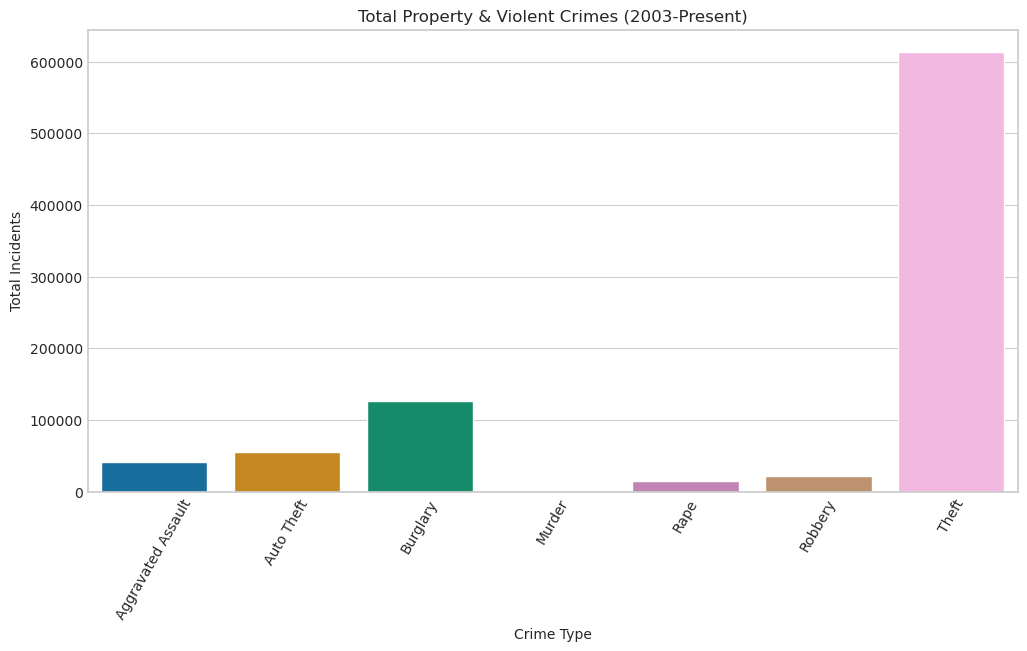

Theft                 613859
Burglary              125754
Auto Theft             54591
Aggravated Assault     40954
Robbery                22221
Rape                   14668
Murder                   679
Name: category_description, dtype: int64

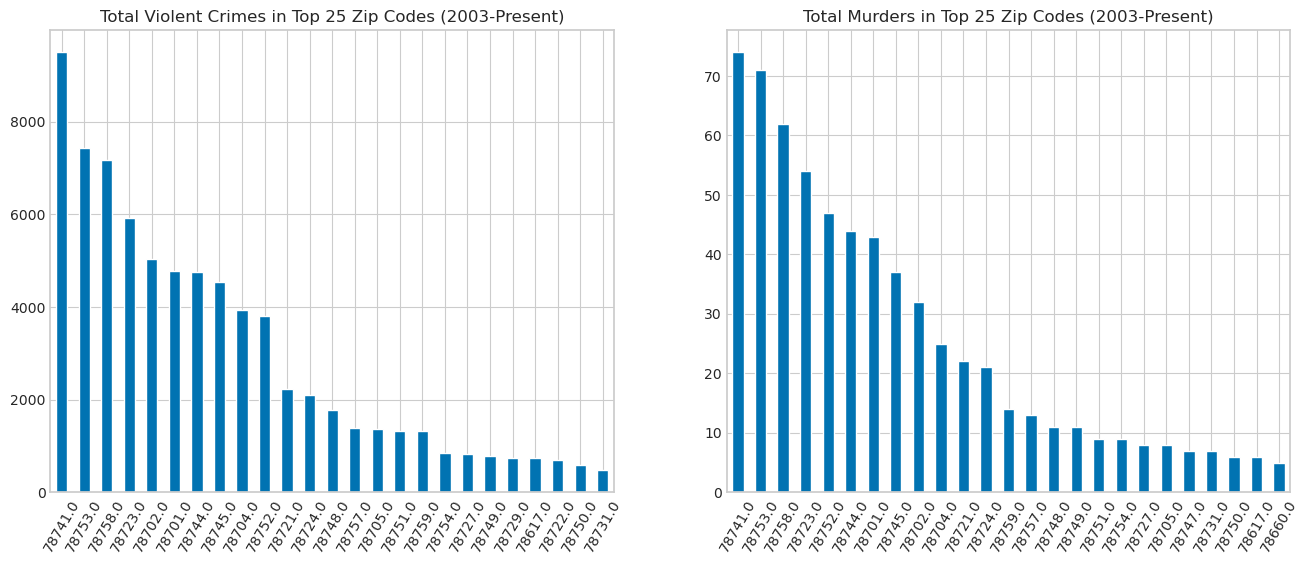

category_description,Aggravated Assault,Murder,Rape,Robbery
zip_code,,,,
0.0,1,0,0,0
78610.0,3,0,4,0
78613.0,54,1,35,65
78617.0,430,6,181,121
78621.0,2,0,0,0
78634.0,1,0,0,0
78640.0,0,0,2,0
78641.0,1,0,0,0
78645.0,0,0,1,0


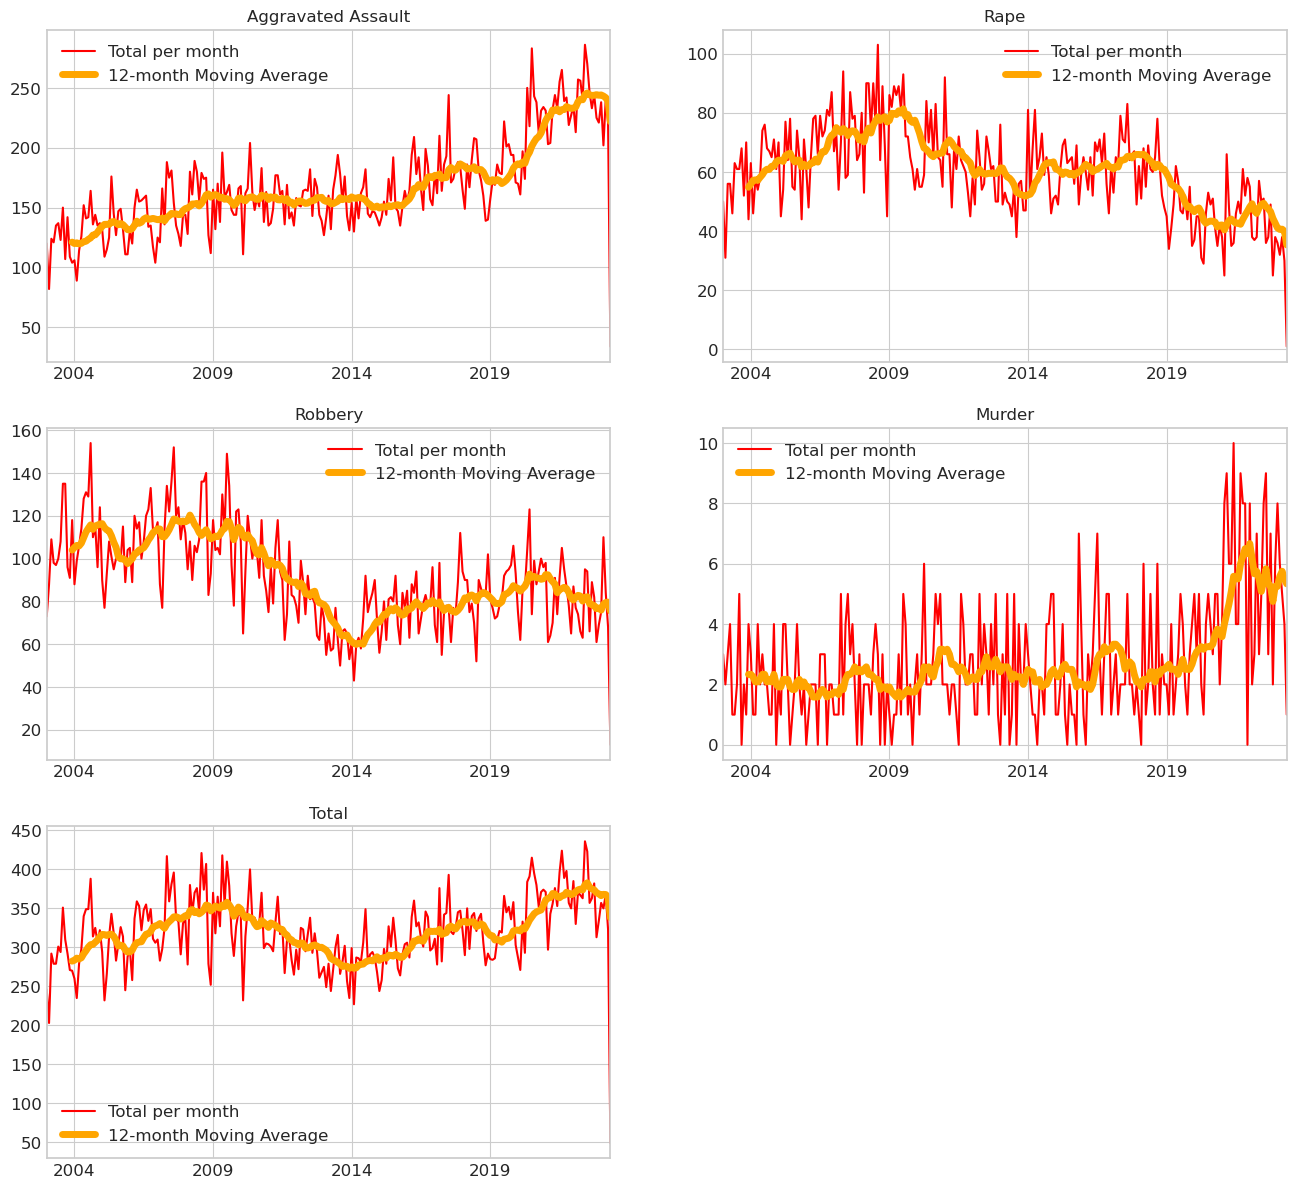

In [21]:
# Filtering data for violent crimes
df_viol = df.query(
    'category_description == ["Aggravated Assault", "Robbery", "Rape", "Murder"]'
)
df_mur = df.query('category_description == "Murder"')
df_agg_asslt = df.query('category_description == "Aggravated Assault"')
df_robbery = df.query('category_description == "Robbery"')
df_rape = df.query('category_description == "Rape"')

# Creating yearly dataframes for overall crime
dfs_overall = [df[df.year == year] for year in range(2017, 2022)]

# Creating yearly dataframes for violent crime
dfs_violent = [df_viol[df_viol.year == year] for year in range(2017, 2022)]

# Creating yearly dataframes for murders
dfs_murders = [df_mur[df_mur.year == year] for year in range(2017, 2022)]

# Plotting total property and violent crimes
plt.figure(figsize=(12, 6), dpi=100)
sb.countplot(x="category_description", data=df).set_title(
    "Total Property & Violent Crimes (2003-Present)"
)
plt.xlabel("Crime Type")
plt.ylabel("Total Incidents")
plt.xticks(rotation=60)
plt.show()

# Displaying count of each crime category
display(df.category_description.value_counts())

# Plotting total violent crimes and murders by zip code
fig, axs = plt.subplots(figsize=(16, 6), ncols=2, dpi=100)
df_viol.zip_code.value_counts().head(25).plot.bar(
    ax=axs[0], title="Total Violent Crimes in Top 25 Zip Codes (2003-Present)", rot=60
)
df_mur.zip_code.value_counts().head(25).plot.bar(
    ax=axs[1], title="Total Murders in Top 25 Zip Codes (2003-Present)", rot=60
)
plt.show()

# Creating frequency tables for violent crimes and murders by zip code
viol_freq = pd.crosstab(df_viol.zip_code, df_viol.category_description)
mur_freq = pd.crosstab(df_mur.zip_code, df_mur.category_description)
display(viol_freq)

# Creating monthly dataframes for violent crimes
monthly_viol = pd.DataFrame(
    df_viol[df_viol["category_description"] == "Aggravated Assault"]
    .resample("M")
    .size()
)
monthly_viol.columns = ["Aggravated Assault"]

for crime_type in df_viol["category_description"].unique():
    monthly_viol[crime_type] = pd.DataFrame(
        df_viol[df_viol["category_description"] == crime_type].resample("M").size()
    )
monthly_viol["Total"] = monthly_viol.sum(axis=1)

# Plotting monthly trends for each type of violent crime
plt.figure(figsize=(16, 25), dpi=100)

i = 521
for crime_type in monthly_viol.columns:
    plt.subplot(i)
    monthly_viol[crime_type].plot(color="red", linewidth=1.5, label="Total per month")
    monthly_viol[crime_type].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12-month Moving Average"
    )
    plt.title(crime_type, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i += 1
viol_freq.to_csv("viol_freq.csv")


In [23]:
display(monthly_viol.head())
display(viol_freq.head())


,Aggravated Assault,Rape,Robbery,Murder,Total
occurred_date,,,,,
2003-01-31,120,50,73,3,246
2003-02-28,82,31,88,2,203
2003-03-31,124,56,109,3,292
2003-04-30,121,56,98,4,279
2003-05-31,135,46,97,1,279


category_description,Aggravated Assault,Murder,Rape,Robbery
zip_code,,,,
0.0,1,0,0,0
78610.0,3,0,4,0
78613.0,54,1,35,65
78617.0,430,6,181,121
78621.0,2,0,0,0


In [24]:
viol_freq.to_csv("viol_freq.csv")

### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

<Figure size 1200x600 with 0 Axes>

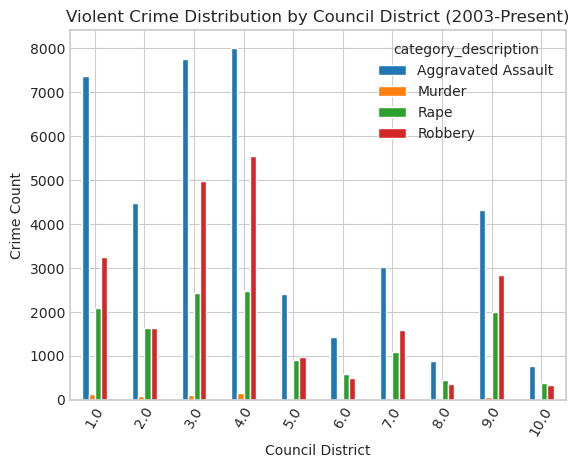

<Figure size 1200x600 with 0 Axes>

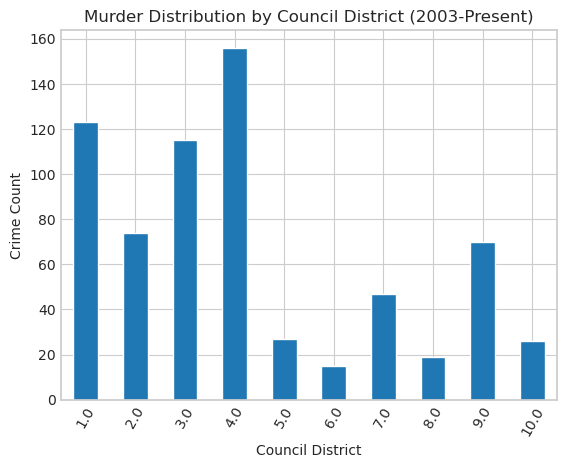

<Figure size 1200x600 with 0 Axes>

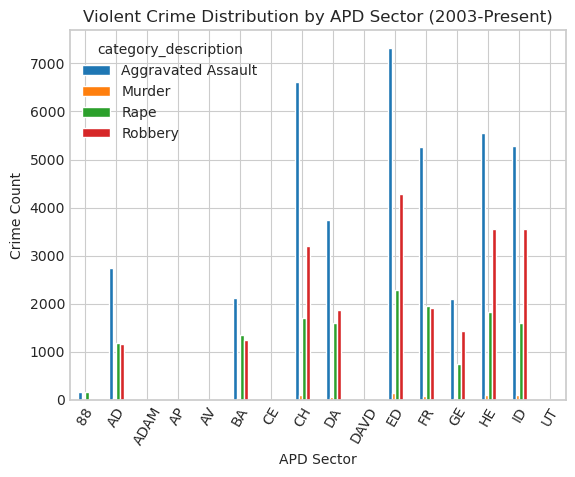

<Figure size 1200x600 with 0 Axes>

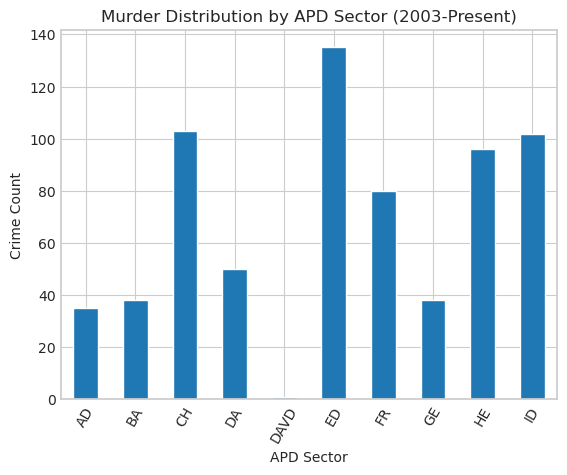

<Figure size 1200x600 with 0 Axes>

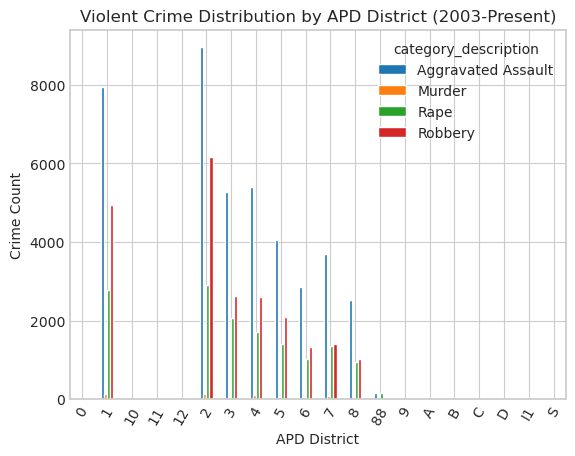

<Figure size 1200x600 with 0 Axes>

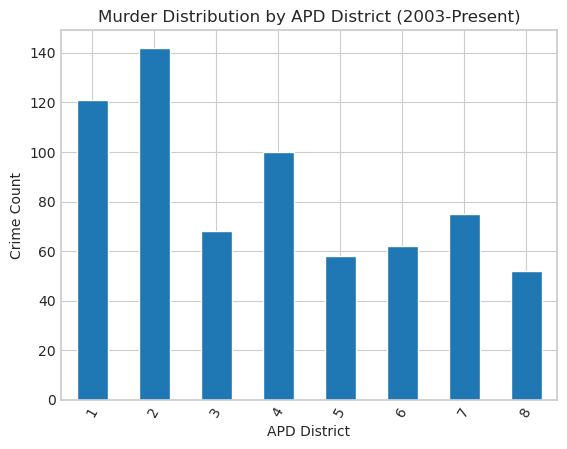

In [11]:
# Plotting violent crime distribution by council district
plt.figure(figsize=(12, 6), dpi=100)
pd.crosstab(df_viol.council_district, df_viol.category_description).plot.bar(
    rot=60,
    xlabel="Council District",
    ylabel="Crime Count",
    title="Violent Crime Distribution by Council District (2003-Present)",
)
plt.show()

# Plotting murder distribution by council district
plt.figure(figsize=(12, 6), dpi=100)
pd.crosstab(df_mur.council_district, df_mur.category_description).plot.bar(
    rot=60,
    xlabel="Council District",
    ylabel="Crime Count",
    title="Murder Distribution by Council District (2003-Present)",
    legend=False,
)
plt.show()

# Plotting violent crime distribution by APD sector
plt.figure(figsize=(12, 6), dpi=100)
pd.crosstab(df_viol.apd_sector, df_viol.category_description).plot.bar(
    rot=60,
    xlabel="APD Sector",
    ylabel="Crime Count",
    title="Violent Crime Distribution by APD Sector (2003-Present)",
)
plt.show()

# Plotting murder distribution by APD sector
plt.figure(figsize=(12, 6), dpi=100)
pd.crosstab(df_mur.apd_sector, df_mur.category_description).plot.bar(
    rot=60,
    xlabel="APD Sector",
    ylabel="Crime Count",
    title="Murder Distribution by APD Sector (2003-Present)",
    legend=False,
)
plt.show()

# Plotting violent crime distribution by APD district
plt.figure(figsize=(12, 6), dpi=100)
pd.crosstab(df_viol.apd_district, df_viol.category_description).plot.bar(
    rot=60,
    xlabel="APD District",
    ylabel="Crime Count",
    title="Violent Crime Distribution by APD District (2003-Present)",
)
plt.show()

# Plotting murder distribution by APD district
plt.figure(figsize=(12, 6), dpi=100)
pd.crosstab(df_mur.apd_district, df_mur.category_description).plot.bar(
    rot=60,
    xlabel="APD District",
    ylabel="Crime Count",
    title="Murder Distribution by APD District (2003-Present)",
    legend=False,
)
plt.show()


### Violent crime and murder distribution by location type

category_description,Aggravated Assault,Murder,Rape,Robbery
location_type,,,,
ABANDONED/CONDEMNED STRUCTURE,25,1,17,13
AIR / BUS / TRAIN TERMINAL,137,1,26,132
AMUSEMENT PARK,2,0,1,1
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,3,0,0,0
ATM SEPARATE FROM BANK,2,0,0,11
AUTO DEALERSHIP NEW / USED,18,0,2,3
BANK / SAVINGS & LOAN,19,1,11,424
BAR / NIGHTCLUB,828,13,173,164
CAMP / CAMPGROUND,66,2,13,8


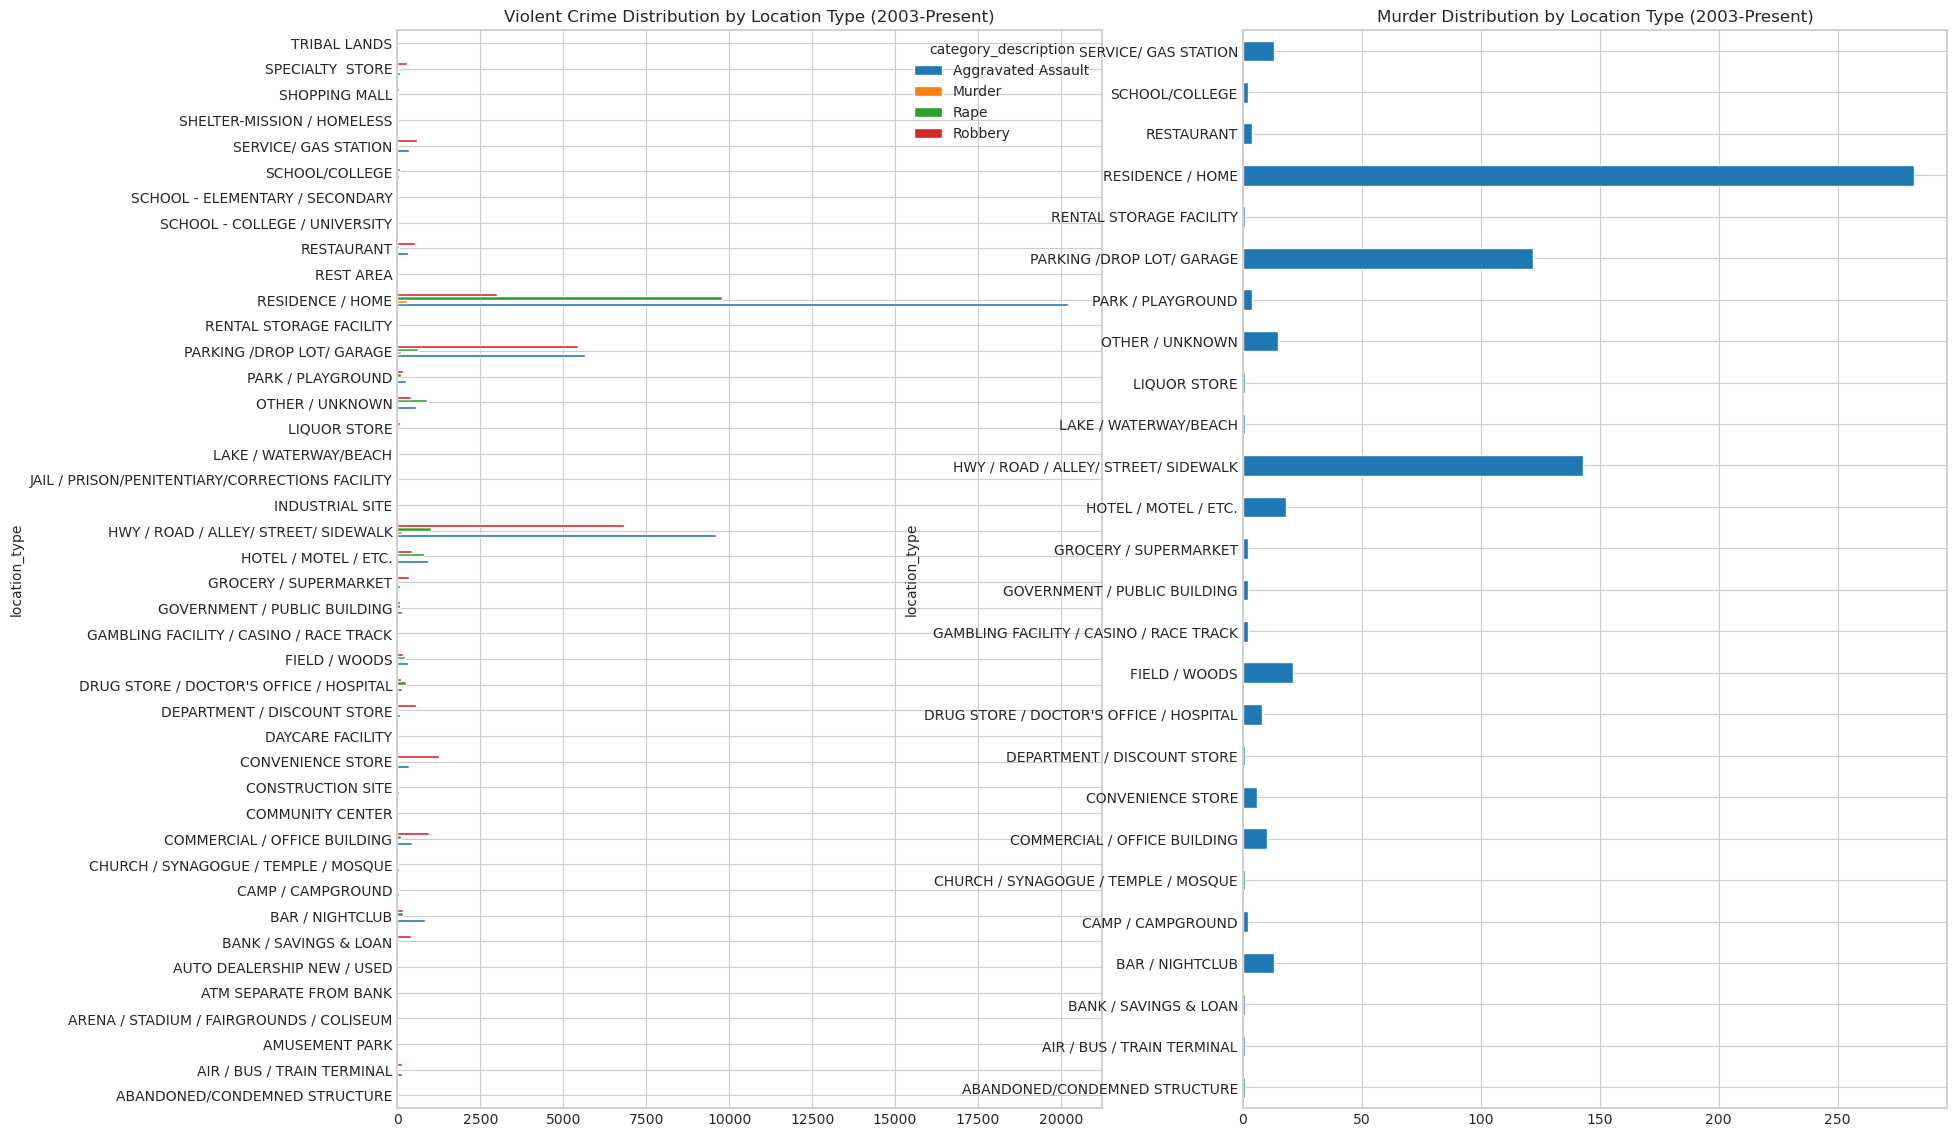

In [12]:
# Calculating violent crime distribution by location type
viol_loc = pd.crosstab(df_viol.location_type, df_viol.category_description)
display(viol_loc)

# Calculating murder distribution by location type
mur_loc = pd.crosstab(df_mur.location_type, df_mur.category_description)

# Plotting violent crime distribution by location type
fig, axs = plt.subplots(figsize=(20, 14), dpi=100, ncols=2)
viol_loc.plot.barh(
    title="Violent Crime Distribution by Location Type (2003-Present)", ax=axs[0]
)
mur_loc.plot.barh(
    title="Murder Distribution by Location Type (2003-Present)", legend=False, ax=axs[1]
)
plt.show()

# Saving the violent crime distribution by location type to a CSV file
viol_loc.to_csv("viol_loc.csv")


### How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

In [13]:
def create_heatmap(df, outfile):
    coords_heat = df[(df["latitude"].notnull()) & (df["longitude"].notnull())]

    map_austin = folium.Map(
        location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12
    )
    map_austin.add_child(
        plugins.HeatMap(coords_heat[["latitude", "longitude"]].values, radius=15)
    )
    map_austin.save(outfile)


# Create heat map for Aggravated Assault
create_heatmap(df_agg_asslt, "agg_asslt_heatmap.html")

# Create heat map for Robbery
create_heatmap(df_robbery, "agg_robbery_heatmap.html")

# Create heat map for Murder
create_heatmap(df_mur, "mur_heatmap.html")


### Are there any addresses where violent crime and murder occurs frequently?

In [14]:
# Show addresses with 50 or more reported violent crimes
df_viol_address_counts = df_viol.address.value_counts()
addresses_with_50_or_more_violent_crimes = df_viol_address_counts[df_viol_address_counts >= 50].to_frame()
addresses_with_50_or_more_violent_crimes


,address
00 BLOCK UNKNOWN,174
1137 GUNTER ST,158
1030 NORWOOD PARK BLVD,152
900 BLOCK E 32ND ST,151
500 E 7TH ST,143
...,...
1100 REINLI ST,51
9133 NORTHGATE BLVD,51
2124 BURTON DR,50
717 E 7TH ST,50


In [15]:
# Show addresses with 2 or more reported murders
df_mur_address_counts = df_mur.address.value_counts()
addresses_with_2_or_more_murders = df_mur_address_counts[df_mur_address_counts >= 2].to_frame()
addresses_with_2_or_more_murders


,address
4700 E RIVERSIDE DR,3
6409 SPRINGDALE RD,3
6407 SPRINGDALE RD,3
8610 N LAMAR BLVD,3
8800 N IH 35 SVRD SB,3
400 E 6TH ST,3
7100 N IH 35 SVRD SB,3
601 E 15TH ST,3
6600 ED BLUESTEIN BLVD SB,3
617 E 7TH ST,2


In [16]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")
df_21.to_csv("df_21.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")
df_viol_21.to_csv("df_viol_21.csv")

df_mur_17.to_csv("df_mur_17.csv")
df_mur_18.to_csv("df_mur_18.csv")
df_mur_19.to_csv("df_mur_19.csv")
df_mur_20.to_csv("df_mur_20.csv")
df_mur_21.to_csv("df_mur_21.csv")

df_viol.to_csv("df_viol.csv")
df_mur.to_csv("df_mur.csv")
df_agg_asslt.to_csv("df_agg_asslt.csv")
df_rape.to_csv("df_rape.csv")

In [17]:
df_53 = df[df.zip_code == 78753]
df_05 = df[df.zip_code == 78705]
df_41 = df[df.zip_code == 78741]

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_05.to_csv("df_05.csv")
